# Predict Machine Failure Classification

Predict machine failure with machine type, temperature, speed, and other data. Model used is XGBoost and achieve xxx accuracy.

In [1]:
# Import libraries and setup
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [2]:
# Import data and preview
df = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


# Data Preprocessing

- Drop id column since it is not contain information
- Renaming some of the column
- Use numeric variable on product id column
- Create a new feature ('Torque'*'Rotational speed') and ('Torque'*'Tool wear')
- One hot encode on 'Type' column


In [3]:
# Drop column 'id'
df.drop(['id'],axis=1,inplace=True)

# Renaming column
df.rename(columns = {'Air temperature [K]':'Air_temperature',
                     'Process temperature [K]':'Process_temperature',
                     'Rotational speed [rpm]':'Rotational_speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool_wear'}, inplace=True)

df.head()

,Product ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
# Filter only numeric variable on product id
df["Product ID"] = pd.to_numeric(df["Product ID"].str.slice(start=1))

# Create new features
df['Torque * Rotational_speed'] = df['Torque'] * df['Rotational_speed']
df['Torque * Tool_wear'] = df['Torque'] * df['Tool_wear']
df.head()

,Product ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine failure,TWF,HDF,PWF,OSF,RNF,Torque * Rotational_speed,Torque * Tool_wear
0,50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,57615.6,5054.0
1,20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,51186.9,5820.0
2,49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,47832.5,662.5
3,53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,67513.2,8727.1
4,24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,58091.4,1203.6


In [5]:
# Split xy variable
X = df.drop(['Machine failure'], axis=1)
y = df['Machine failure']

X.head()

,Product ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,Torque * Rotational_speed,Torque * Tool_wear
0,50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,57615.6,5054.0
1,20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,51186.9,5820.0
2,49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,47832.5,662.5
3,53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,67513.2,8727.1
4,24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,58091.4,1203.6


In [6]:
# Encode 'type' variable
from sklearn.preprocessing import OneHotEncoder

s = (X.dtypes == 'object')
object_cols = list(s[s].index)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]))
OH_cols.index = X.index
X = X.drop('Type', axis=1)
X = pd.concat([X, OH_cols], axis=1)
X.columns = X.columns.astype(str)
X.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Product ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,Torque * Rotational_speed,Torque * Tool_wear,0,1,2
0,50096,300.6,309.6,1596,36.1,140,0,0,0,0,0,57615.6,5054.0,0.0,1.0,0.0
1,20343,302.6,312.1,1759,29.1,200,0,0,0,0,0,51186.9,5820.0,0.0,0.0,1.0
2,49454,299.3,308.5,1805,26.5,25,0,0,0,0,0,47832.5,662.5,0.0,1.0,0.0
3,53355,301.0,310.9,1524,44.3,197,0,0,0,0,0,67513.2,8727.1,0.0,1.0,0.0
4,24050,298.0,309.0,1641,35.4,34,0,0,0,0,0,58091.4,1203.6,0.0,0.0,1.0


# Data Modelling

Machine learning model using xgboost and using optuna for hyperparameter tuning.

In [7]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.85)
X_valid.head()

,Product ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,Torque * Rotational_speed,Torque * Tool_wear,0,1,2
39963,52324,304.4,313.7,1754,29.3,7,0,0,0,0,0,51392.2,205.1,0.0,1.0,0.0
135760,53290,300.7,310.8,1534,50.7,69,0,0,0,0,0,77773.8,3498.3,0.0,1.0,0.0
86288,48739,298.2,308.2,1686,30.8,176,0,0,0,0,0,51928.8,5420.8,0.0,1.0,0.0
46457,30252,296.6,307.4,1426,41.5,189,0,0,0,0,0,59179.0,7843.5,1.0,0.0,0.0
124566,55970,297.4,308.5,1383,43.9,47,0,0,0,0,0,60713.7,2063.3,0.0,1.0,0.0


In [ ]:
# # Xgboost hyperparameter tuning
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import ConfusionMatrixDisplay
# import optuna
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     x,y = X_train, y_train
#     x_test,y_test = X_valid,y_valid
    
#     learning_rate = trial.suggest_float("learning_rate",0.05,0.3)
#     max_depth = trial.suggest_int("max_depth",3,10)
#     colsample_bytree = trial.suggest_float("colsample_bytree",0,0.8)
#     n_estimators = trial.suggest_int("n_estimators",100,2000)
    
#     rf = XGBClassifier(objective='binary:logistic',
#                        eval_metric='auc',
#                        random_state=42,
#                        n_estimators=n_estimators, 
#                        learning_rate = learning_rate, 
#                        colsample_bytree = colsample_bytree,
#                        min_child_weight=1,
#                        # gamma=gamma,
#                        max_depth=max_depth)

        
#     rf.fit(x,y)
        
#     preds = rf.predict_proba(x_test)[:, 1]
        
#     final_valid = []
#     final_valid.extend(y_test)
#     final_valid = np.array(final_valid)
        
#     roc_score = roc_auc_score(final_valid, preds)  
    
#     return roc_score
    

# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=3)

[I 2023-06-26 16:32:55,260] A new study created in memory with name: no-name-04ef2e04-adcd-4eb7-8a05-a1752b68dbc0
[I 2023-06-26 16:34:19,613] Trial 0 finished with value: 0.9608055273026082 and parameters: {'learning_rate': 0.18951617496779638, 'max_depth': 10, 'colsample_bytree': 0.5712978467250052, 'n_estimators': 880}. Best is trial 0 with value: 0.9608055273026082.
[I 2023-06-26 16:34:59,936] Trial 1 finished with value: 0.9646168481521527 and parameters: {'learning_rate': 0.14616593624088525, 'max_depth': 5, 'colsample_bytree': 0.3822518733261716, 'n_estimators': 974}. Best is trial 1 with value: 0.9646168481521527.


Final ROC AUC score: 0.9668593154874237


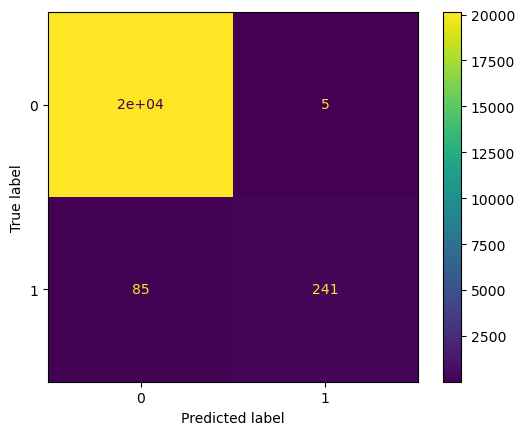

In [9]:
# Model build

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

my_model5 = XGBClassifier(n_estimators=712, 
                    objective='binary:logistic', 
                    eval_metric='auc', 
                    random_state=42, 
                    learning_rate = 0.06420488832587695, 
                    colsample_bytree = 0.008558654297503914,
                    min_child_weight=1,
                    max_depth=10,
                    gamma=3.2495198457155188
                         )

my_model5.fit(X_train, 
              y_train)

predictions5 = my_model5.predict_proba(X_valid)[:, 1]

final_valid_predictions5 = []
final_valid = []

final_valid_predictions5.extend(predictions5)
final_valid.extend(y_valid)

final_valid_predictions5 = np.array(final_valid_predictions5)
final_valid = np.array(final_valid)

roc_score = roc_auc_score(final_valid, predictions5)
print(f"Final ROC AUC score: {roc_score}")
ConfusionMatrixDisplay.from_predictions(final_valid, final_valid_predictions5.round(0).astype(int))

Model reached ROC-AUC score 96.68%

# Feature Importance

Based on SHAP method,top 5 most importan variables from determining machine failure are:
- Rotational Speed
- HDF
- Torque
- Product ID
- OSF

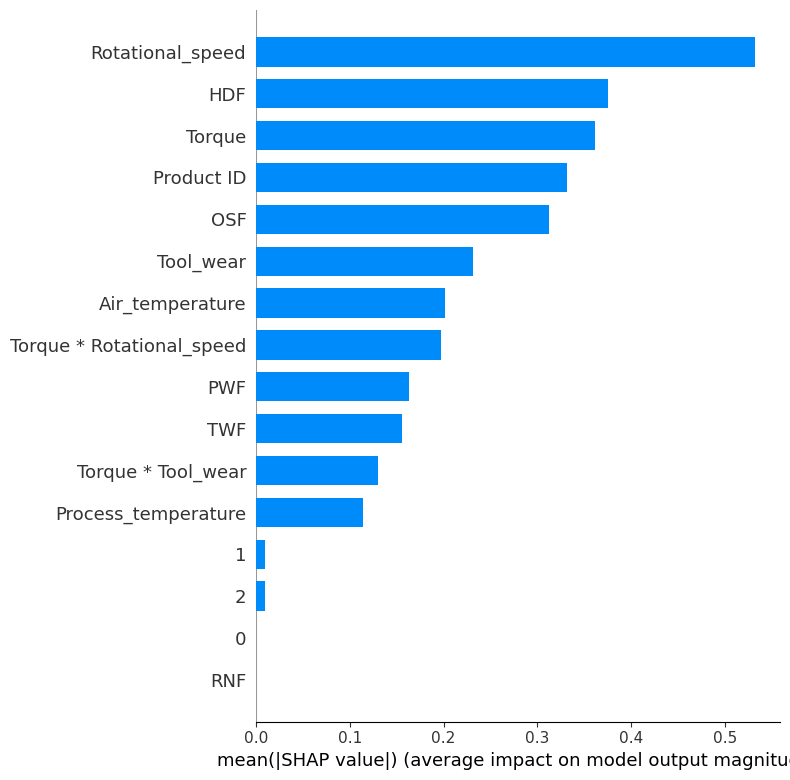

In [14]:
import shap
from matplotlib import pyplot as plt

# Feature Importance with SHAP method
explainer = shap.TreeExplainer(my_model5)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, plot_type="bar")

In [ ]:
# # Prepare test data for prediction
# test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
# test.drop(['id'],axis=1,inplace=True)
# test.rename(columns = {'Air temperature [K]':'Air_temperature',
#                      'Process temperature [K]':'Process_temperature',
#                      'Rotational speed [rpm]':'Rotational_speed',
#                      'Torque [Nm]':'Torque',
#                      'Tool wear [min]':'Tool_wear'}, inplace=True)

# test["Product ID"] = pd.to_numeric(test["Product ID"].str.slice(start=1))
# test['Torque * Rotational_speed'] = test['Torque'] * test['Rotational_speed']
# test['Torque * Tool_wear'] = df['Torque'] * df['Tool_wear']

# s = (test.dtypes == 'object')
# object_cols = list(s[s].index)
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols = pd.DataFrame(OH_encoder.fit_transform(test[object_cols]))
# OH_cols.index = test.index
# test = test.drop('Type', axis=1)
# test = pd.concat([test, OH_cols], axis=1)
# test.columns = X.columns.astype(str)

In [ ]:
# # Prediction submit
# predictions_test = pd.DataFrame(my_model5.predict_proba(test)[:, 1])

# id_test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
# id_test = id_test['id']

# submission = pd.concat([id_test,predictions_test], axis=1)
# submission.rename(columns = {0:'Machine failure'},inplace=True)

# submission.to_csv(r"submission7.csv", index=False)

